In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

LR images directory: C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/LR_64_images
HR images directory: C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/HR_256_images
Contents of LR images directory: ['BACTERIA-1008087-0001.jpeg', 'BACTERIA-1025587-0001.jpeg', 'BACTERIA-1027194-0001.jpeg', 'BACTERIA-1033441-0001.jpeg', 'BACTERIA-103798-0001.jpeg']
Contents of HR images directory: ['BACTERIA-1008087-0001.jpeg', 'BACTERIA-1025587-0001.jpeg', 'BACTERIA-1027194-0001.jpeg', 'BACTERIA-1033441-0001.jpeg', 'BACTERIA-103798-0001.jpeg']
Loading images from C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/LR_64_images and C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/HR_256_images


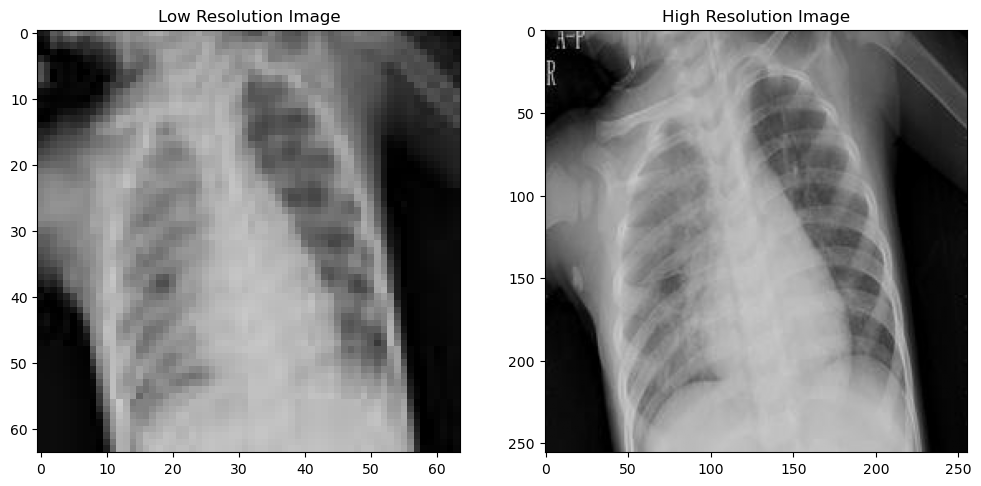

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten, UpSampling2D, LeakyReLU, Dense, Input, add
from sklearn.model_selection import train_test_split

# Define function to load and resize images
def load_resize_images(lr_path, hr_path, lr_shape, hr_shape, n):
    print(f"Loading images from {lr_path} and {hr_path}")
    
    if not os.path.exists(lr_path):
        raise FileNotFoundError(f"The low-resolution image directory does not exist: {lr_path}")
    if not os.path.exists(hr_path):
        raise FileNotFoundError(f"The high-resolution image directory does not exist: {hr_path}")
    
    lr_list = os.listdir(lr_path)[:n]
    hr_list = os.listdir(hr_path)[:n]
    
    lr_images = []
    hr_images = []
    
    for img in lr_list:
        img_lr_path = os.path.join(lr_path, img)
        img_lr = cv2.imread(img_lr_path)
        if img_lr is None:
            print(f"Failed to load image: {img_lr_path}")
            continue
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        img_lr = cv2.resize(img_lr, (lr_shape[0], lr_shape[1]))
        lr_images.append(img_lr)
    
    for img in hr_list:
        img_hr_path = os.path.join(hr_path, img)
        img_hr = cv2.imread(img_hr_path)
        if img_hr is None:
            print(f"Failed to load image: {img_hr_path}")
            continue
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = cv2.resize(img_hr, (hr_shape[0], hr_shape[1]))
        hr_images.append(img_hr)
    
    lr_images = np.array(lr_images) / 255.
    hr_images = np.array(hr_images) / 255.
    
    return lr_images, hr_images

# Define the base directory where your project is located
base_dir = "C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE"

# Define the paths to the LR and HR image directories
lr_images_dir = os.path.join(base_dir, "chest_xray/LR_64_images")
hr_images_dir = os.path.join(base_dir, "chest_xray/HR_256_images")

# Print the paths to verify
print(f"LR images directory: {lr_images_dir}")
print(f"HR images directory: {hr_images_dir}")

# Check if directories exist and list their contents
if os.path.exists(lr_images_dir):
    print(f"Contents of LR images directory: {os.listdir(lr_images_dir)[:5]}")
else:
    print(f"LR images directory does not exist: {lr_images_dir}")

if os.path.exists(hr_images_dir):
    print(f"Contents of HR images directory: {os.listdir(hr_images_dir)[:5]}")
else:
    print(f"HR images directory does not exist: {hr_images_dir}")

# Define input pairs of LR and HR image shapes
image_pairs = {
    "pair1": [(32, 32, 3), (128, 128, 3)],
    "pair2": [(64, 64, 3), (256, 256, 3)],
    "pair3": [(128, 128, 3), (512, 512, 3)]
}

# Choose the image pair to use
chosen_pair = "pair2"  # Change this to select a different pair

# Get the LR and HR shapes for the chosen pair
lr_shape, hr_shape = image_pairs[chosen_pair]

# Load and resize images
lr_images, hr_images = load_resize_images(lr_images_dir, hr_images_dir, lr_shape, hr_shape, n=510)

# Sanity check: Display a random image from the dataset
import random
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.title("Low Resolution Image")
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.title("High Resolution Image")
plt.show()

# Split the dataset
train_lr, test_lr, train_hr, test_hr = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

# Define input layers
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

# Continue with the rest of your code...


In [3]:
# generator

# Residual block
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])
# Upscale the image 2x
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model
num_res_block = 16
# Generator Model
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

In [4]:
# Discriminator

# Small block inside the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    return disc_model
# Discriminator Model
def create_disc(disc_ip):
    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(disc_ip, validity)

In [5]:
# define vgg19

# from keras.applications import VGG19
# Build the VGG19 model upto 10th layer 
# Used to extract the features of high res imgaes
#def build_vgg():
#    vgg = VGG19(weights="imagenet")
 #   vgg.outputs = [vgg.layers[9].output]
 #   img = Input(shape=hr_shape)
 #   img_features = vgg(img)
 #   return Model(img, img_features)

from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [6]:
# combined model

# Attach the generator and discriminator
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model([lr_ip, hr_ip],[validity,gen_features])

In [7]:
# optimize a model 

generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam",      
  metrics=['accuracy'])
#vgg = build_vgg()
if chosen_pair == "pair1":
    vgg=build_vgg((128,128,3))  #vgg=build_vgg((128,128,3))
elif chosen_pair == "pair2":
    vgg=build_vgg((256,256,3))
else:
    vgg=build_vgg((512,512,3))
    
vgg.trainable = False
print(vgg.summary())
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=
  [1e-3, 1], optimizer="adam")



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0 

In [8]:
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 256, 256, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    1389125   ['model[0][0]']               
                                                          77                                

In [9]:
# training a model

batch_size = 20
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])
train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)

In [10]:
epochs = 80
gen_losses_store=[]
dis_losses_store=[]
increment=0

for e in range(epochs):
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        gen_imgs = generator.predict_on_batch(lr_imgs)
        #Dont forget to make the discriminator trainable
        discriminator.trainable = True
        
        #Train the discriminator
        d_loss_gen = discriminator.train_on_batch(gen_imgs,
          gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs,
          real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)
        
        #Train the generator
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], 
          [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    
    ## loss_displaying
    gen_losses_store.append(g_loss)
    dis_losses_store.append(d_loss)
    increment=increment+1



1/1 [==============================] - 3s 3s/step
epoch: 1 g_loss: 93.50837438246784 d_loss: [55.64817926  0.81617647]
1/1 [==============================] - 3s 3s/step
epoch: 2 g_loss: 34.215441311106964 d_loss: [0.82180248 0.99264706]
1/1 [==============================] - 3s 3s/step
epoch: 3 g_loss: 29.76794097002815 d_loss: [0.40065989 0.99558823]
1/1 [==============================] - 3s 3s/step
epoch: 4 g_loss: 27.07132687288172 d_loss: [0.06725446 0.99705882]
1/1 [==============================] - 4s 4s/step
epoch: 5 g_loss: 24.293632843915155 d_loss: [0.09667088 0.99558823]
1/1 [==============================] - 3s 3s/step
epoch: 6 g_loss: 21.391924465403836 d_loss: [1.95657948 0.94411764]
1/1 [==============================] - 3s 3s/step
epoch: 7 g_loss: 17.968313665951 d_loss: [2.2259582  0.94264706]
1/1 [==============================] - 3s 3s/step
epoch: 8 g_loss: 15.179895457099466 d_loss: [10.96066426  0.83382353]
1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step
epoch: 9 g_loss: 13.328384399414062 d_loss: [30.63046023  0.69117647]
1/1 [==============================] - 3s 3s/step
epoch: 10 g_loss: 12.03853567908792 d_loss: [8.0436096  0.83529412]
1/1 [==============================] - 3s 3s/step
epoch: 11 g_loss: 11.59234338648179 d_loss: [6.9966416  0.84852941]
1/1 [==============================] - 3s 3s/step
epoch: 12 g_loss: 10.835743511424345 d_loss: [5.08126862 0.83529412]
1/1 [==============================] - 3s 3s/step
epoch: 13 g_loss: 10.39805384243236 d_loss: [3.76868851 0.85147059]
1/1 [==============================] - 3s 3s/step
epoch: 14 g_loss: 10.069860290078555 d_loss: [2.28364534 0.89411765]
1/1 [==============================] - 3s 3s/step
epoch: 15 g_loss: 9.58102243086871 d_loss: [0.64145056 0.94117647]
1/1 [==============================] - 3s 3s/step
epoch: 16 g_loss: 9.290049496818991 d_loss: [1.65809594 0.88088235]
1/1 [==============================] - 3s 3s/step
epo

1/1 [==============================] - 3s 3s/step
epoch: 18 g_loss: 8.82439489925609 d_loss: [0.17150408 0.98382353]
1/1 [==============================] - 3s 3s/step
epoch: 19 g_loss: 8.651734969195198 d_loss: [0.11393667 0.99117647]
1/1 [==============================] - 3s 3s/step
epoch: 20 g_loss: 8.510545814738554 d_loss: [0.3590613 0.975    ]
1/1 [==============================] - 3s 3s/step
epoch: 21 g_loss: 8.343845760121065 d_loss: [0.08995742 0.99264706]
1/1 [==============================] - 3s 3s/step
epoch: 22 g_loss: 8.315971290363985 d_loss: [0.02185538 0.99705882]
1/1 [==============================] - 3s 3s/step
epoch: 23 g_loss: 8.142736406887279 d_loss: [9.53976123e-05 1.00000000e+00]
1/1 [==============================] - 3s 3s/step
epoch: 24 g_loss: 7.969372272491455 d_loss: [0.11347283 0.99264706]
1/1 [==============================] - 4s 4s/step
epoch: 25 g_loss: 7.844376648173613 d_loss: [8.1418868e-04 1.0000000e+00]
1/1 [==============================] - 4s 4s/

1/1 [==============================] - 3s 3s/step
epoch: 27 g_loss: 7.612382524153766 d_loss: [1.60787854e-04 1.00000000e+00]
1/1 [==============================] - 3s 3s/step
epoch: 28 g_loss: 7.543948033276727 d_loss: [9.62986393e-04 1.00000000e+00]
1/1 [==============================] - 4s 4s/step
epoch: 29 g_loss: 7.46873213263119 d_loss: [5.73551605e-04 1.00000000e+00]
1/1 [==============================] - 4s 4s/step
epoch: 30 g_loss: 7.373806055854349 d_loss: [0.02472272 0.99705882]
1/1 [==============================] - 3s 3s/step
epoch: 31 g_loss: 7.313975754906149 d_loss: [0.40446544 0.97794117]
1/1 [==============================] - 3s 3s/step
epoch: 32 g_loss: 7.247828876270967 d_loss: [0.90688638 0.93823529]
1/1 [==============================] - 3s 3s/step
epoch: 33 g_loss: 7.223955294665168 d_loss: [0.36923521 0.96764706]
1/1 [==============================] - 3s 3s/step
epoch: 34 g_loss: 7.227150692659266 d_loss: [10.24412271  0.74852941]
1/1 [==========================

1/1 [==============================] - 3s 3s/step
epoch: 36 g_loss: 6.907033527598662 d_loss: [1.15984468 0.88823529]
1/1 [==============================] - 3s 3s/step
epoch: 37 g_loss: 6.838874283958884 d_loss: [0.15987353 0.97058824]
1/1 [==============================] - 3s 3s/step
epoch: 38 g_loss: 6.7901747927946206 d_loss: [0.2190896  0.97647059]
1/1 [==============================] - 3s 3s/step
epoch: 39 g_loss: 6.72661963631125 d_loss: [2.72268474 0.86323529]
1/1 [==============================] - 3s 3s/step
epoch: 40 g_loss: 6.745014919954188 d_loss: [1.40603476 0.91176471]
1/1 [==============================] - 3s 3s/step
epoch: 41 g_loss: 6.771142623003791 d_loss: [0.39597499 0.96470588]
1/1 [==============================] - 3s 3s/step
epoch: 42 g_loss: 6.557303849388571 d_loss: [0.11580167 0.99264706]
1/1 [==============================] - 3s 3s/step
epoch: 43 g_loss: 6.60957005444695 d_loss: [0.98710168 0.93970588]
1/1 [==============================] - 3s 3s/step
epoch: 

1/1 [==============================] - 3s 3s/step
epoch: 45 g_loss: 6.424637766445384 d_loss: [0.09634849 0.98970588]
1/1 [==============================] - 3s 3s/step
epoch: 46 g_loss: 6.400432278128231 d_loss: [0.06256993 0.99264706]
1/1 [==============================] - 3s 3s/step
epoch: 47 g_loss: 6.260222771588494 d_loss: [1.03831456e-07 1.00000000e+00]
1/1 [==============================] - 3s 3s/step
epoch: 48 g_loss: 6.225287353291231 d_loss: [0.00179348 0.99852941]
1/1 [==============================] - 3s 3s/step
epoch: 49 g_loss: 6.131680292241714 d_loss: [1.30665838e-04 1.00000000e+00]
1/1 [==============================] - 3s 3s/step
epoch: 50 g_loss: 6.157437773311839 d_loss: [5.6164653e-04 1.0000000e+00]
1/1 [==============================] - 3s 3s/step
epoch: 51 g_loss: 6.098923739264993 d_loss: [0.08899915 0.99117647]
1/1 [==============================] - 3s 3s/step
epoch: 52 g_loss: 6.104866224176743 d_loss: [0.50962055 0.95      ]
1/1 [=============================

1/1 [==============================] - 3s 3s/step
epoch: 53 g_loss: 6.14544433705947 d_loss: [1.1569734 0.925    ]
1/1 [==============================] - 3s 3s/step
epoch: 54 g_loss: 6.172257928287282 d_loss: [2.91360864 0.84117647]
1/1 [==============================] - 3s 3s/step
epoch: 55 g_loss: 6.092255311853745 d_loss: [0.89719601 0.85882353]
1/1 [==============================] - 3s 3s/step
epoch: 56 g_loss: 5.98751516903148 d_loss: [0.16888074 0.97058823]
1/1 [==============================] - 3s 3s/step
epoch: 57 g_loss: 5.999491944032557 d_loss: [2.61735277 0.83382353]
1/1 [==============================] - 3s 3s/step
epoch: 58 g_loss: 5.941154816571404 d_loss: [1.6573396  0.90147059]
1/1 [==============================] - 3s 3s/step
epoch: 59 g_loss: 5.954003586488612 d_loss: [0.55034448 0.94705882]
1/1 [==============================] - 4s 4s/step
epoch: 60 g_loss: 5.79819783042459 d_loss: [0.23789557 0.97352941]
1/1 [==============================] - 4s 4s/step
epoch: 61 g

1/1 [==============================] - 3s 3s/step
epoch: 62 g_loss: 5.785403111401727 d_loss: [0.30694343 0.97205882]
1/1 [==============================] - 4s 4s/step
epoch: 63 g_loss: 5.875432968139648 d_loss: [0.25829178 0.975     ]
1/1 [==============================] - 4s 4s/step
epoch: 64 g_loss: 5.687036906971651 d_loss: [1.76557347 0.88235294]
1/1 [==============================] - 3s 3s/step
epoch: 65 g_loss: 5.542261965134564 d_loss: [0.10362441 0.98529411]
1/1 [==============================] - 3s 3s/step
epoch: 66 g_loss: 5.4723811430089615 d_loss: [0.28246124 0.98529412]
1/1 [==============================] - 3s 3s/step
epoch: 67 g_loss: 5.461950638714959 d_loss: [0.31236836 0.98088235]
1/1 [==============================] - 3s 3s/step
epoch: 68 g_loss: 5.63338815464693 d_loss: [1.64332456 0.89558823]
1/1 [==============================] - 4s 4s/step
epoch: 69 g_loss: 5.465000629425049 d_loss: [0.17973841 0.98529411]
1/1 [==============================] - 3s 3s/step
epoch:

1/1 [==============================] - 3s 3s/step
epoch: 71 g_loss: 5.392622022067799 d_loss: [0.38087169 0.97794117]
1/1 [==============================] - 3s 3s/step
epoch: 72 g_loss: 5.356154189390295 d_loss: [0.67579466 0.95      ]
1/1 [==============================] - 3s 3s/step
epoch: 73 g_loss: 5.596995269550996 d_loss: [1.043513   0.93088235]
1/1 [==============================] - 3s 3s/step
epoch: 74 g_loss: 5.487348332124598 d_loss: [0.36459876 0.97941176]
1/1 [==============================] - 3s 3s/step
epoch: 75 g_loss: 5.1855425554163315 d_loss: [2.06693749 0.95294118]
1/1 [==============================] - 3s 3s/step
epoch: 76 g_loss: 5.172798717723174 d_loss: [0.75264057 0.94705882]
1/1 [==============================] - 3s 3s/step
epoch: 77 g_loss: 5.201439212350285 d_loss: [0.10447315 0.99117647]
1/1 [==============================] - 3s 3s/step
epoch: 78 g_loss: 5.238203329198501 d_loss: [0.00402726 0.99852941]
1/1 [==============================] - 3s 3s/step
epoch

1/1 [==============================] - 3s 3s/step
epoch: 80 g_loss: 5.292976183049819 d_loss: [0.0249027  0.99705882]


In [11]:
# model evaluation

label = np.ones((len(test_lr),1))
test_features = vgg.predict(test_hr)
eval,_,_ = gan_model.evaluate([test_lr, test_hr], [label,test_features])

6/6 [==============================] - 100s 16s/step - loss: 7.4148 - model_1_loss: 4.6001 - model_2_loss: 7.4102


In [12]:
# model prediction

#test_prediction = generator.predict_on_batch(test_lr)

In [13]:
#test_prediction

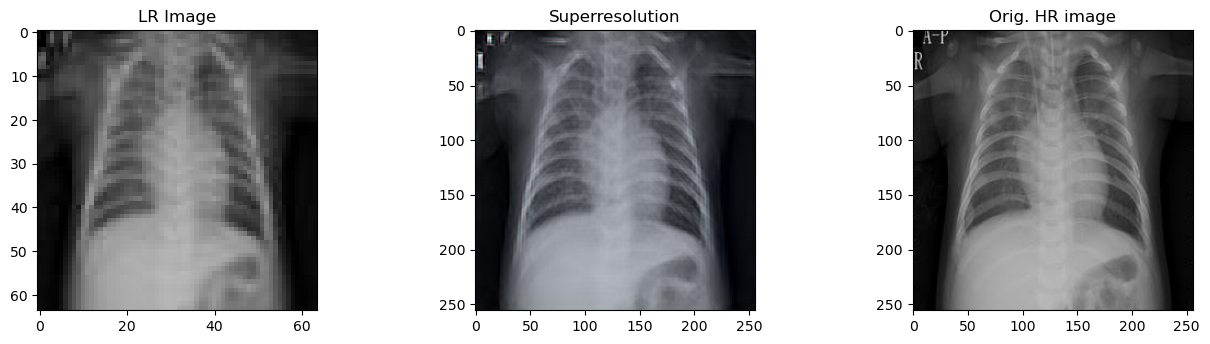

1/1 [==============================] - 1s 1s/step


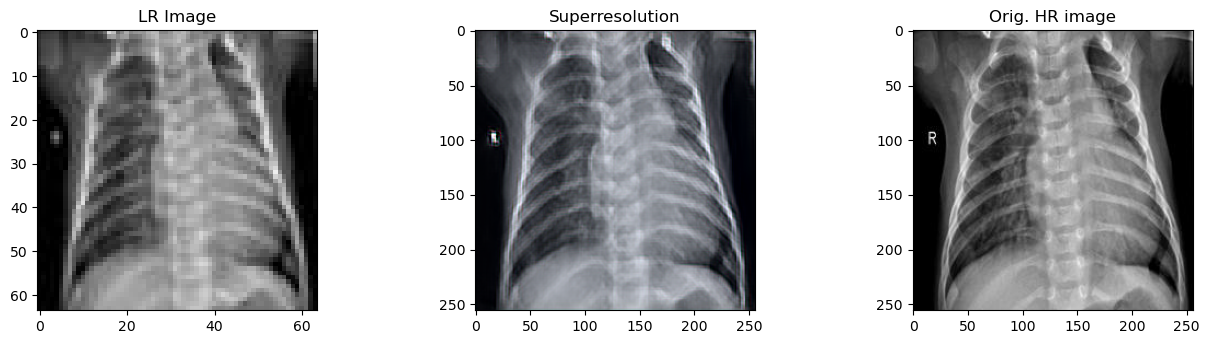

In [14]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

#generator = load_model('C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/SRGAN-with_keras/gen_e_10.h5', compile=False)


[X1, X2] = [test_lr, test_hr]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image=generator.predict_on_batch(src_image)
#gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(np.clip(src_image[0,:,:,:],0,1))
plt.subplot(232)
plt.title('Superresolution')
#plt.imshow(gen_image)
#plt.imshow(gen_image[0,:,:,:])
plt.imshow(np.clip(gen_image[0,:,:,:],0,1))
plt.subplot(233)
plt.title('Orig. HR image')
#plt.imshow(tar_image[0,:,:,:])
plt.imshow(np.clip(tar_image[0,:,:,:],0,1))

plt.show()


################################################
sreeni_lr = cv2.imread( "C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE/chest_xray/LR_64_images/BACTERIA-7422-0001.jpeg")
sreeni_hr = cv2.imread("C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE/chest_xray/HR_256_images/BACTERIA-7422-0001.jpeg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
#plt.imshow(sreeni_lr[0,:,:,:])
plt.imshow(np.clip(sreeni_lr[0,:,:,:],0,1))
plt.subplot(232)
plt.title('Superresolution')
#plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.imshow(np.clip(generated_sreeni_hr[0,:,:,:],0,1))
plt.subplot(233)
plt.title('Orig. HR image')
#plt.imshow(sreeni_hr[0,:,:,:])
plt.imshow(np.clip(sreeni_hr[0,:,:,:],0,1))

plt.show()

In [15]:

# =======================DIFFERENT METRICS FOR EVALUATING PERFORMANCE OF A MODEL:==============================


In [16]:
import tensorflow as tf
from tensorflow.keras.losses import mse
from tensorflow.image import ssim
import matplotlib.pyplot as plt

In [17]:
# convert the image nto tensor
generated_sreeni_hr_tensor=tf.convert_to_tensor(generated_sreeni_hr,dtype=tf.float32)
sreeni_hr_tensor=tf.convert_to_tensor(sreeni_hr,dtype=tf.float32)
print('generated_sreeni_hr_tensor shape:',generated_sreeni_hr_tensor.shape)
print('sreeni_hr_tensor shape:',sreeni_hr_tensor.shape)

generated_sreeni_hr_tensor shape: (1, 256, 256, 3)
sreeni_hr_tensor shape: (1, 256, 256, 3)


In [18]:
# calculate the PSNR
mse_value=mse(sreeni_hr_tensor,generated_sreeni_hr_tensor)
psnr_value=tf.squeeze(tf.image.psnr(sreeni_hr_tensor,generated_sreeni_hr_tensor,max_val=1.1))
psnr_value

<tf.Tensor: shape=(), dtype=float32, numpy=24.993471>

In [19]:
# calculate ssim (structural similarity index measure)
ssim_value=ssim(sreeni_hr_tensor,generated_sreeni_hr_tensor,max_val=1.0)
ssim_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6435892], dtype=float32)>

In [20]:
psnr_title=f"PSNR:{psnr_value.numpy():.2f}dB"
ssim_title=f"SSIM:{ssim_value.numpy().item():.4f}"

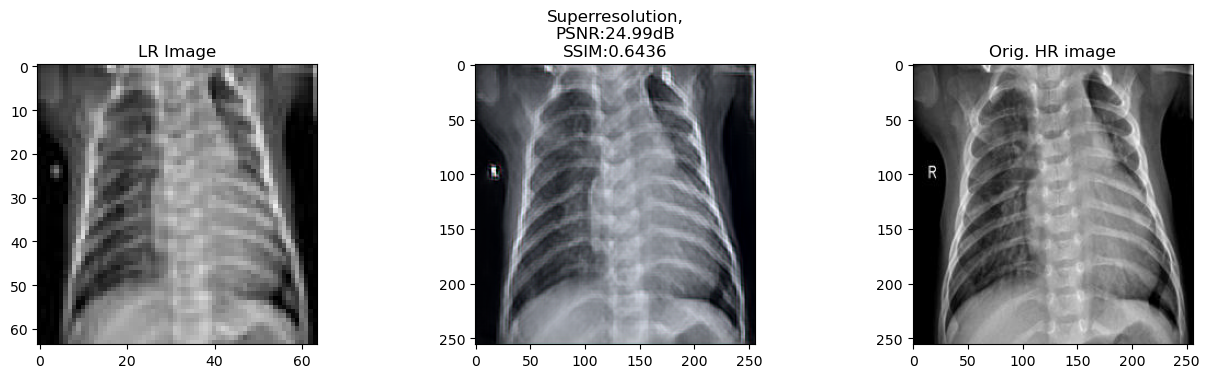

In [21]:
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
#plt.imshow(sreeni_lr[0,:,:,:])
plt.imshow(np.clip(sreeni_lr[0,:,:,:],0,1))
plt.subplot(232)
plt.title('Superresolution,'+'\n'+psnr_title+'\n'+ssim_title)
#plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.imshow(np.clip(generated_sreeni_hr[0,:,:,:],0,1))
plt.subplot(233)
plt.title('Orig. HR image')
#plt.imshow(sreeni_hr[0,:,:,:])
plt.imshow(np.clip(sreeni_hr[0,:,:,:],0,1))

plt.show()

In [22]:
dd=dis_losses_store
dd=[i[1] for i in dd]

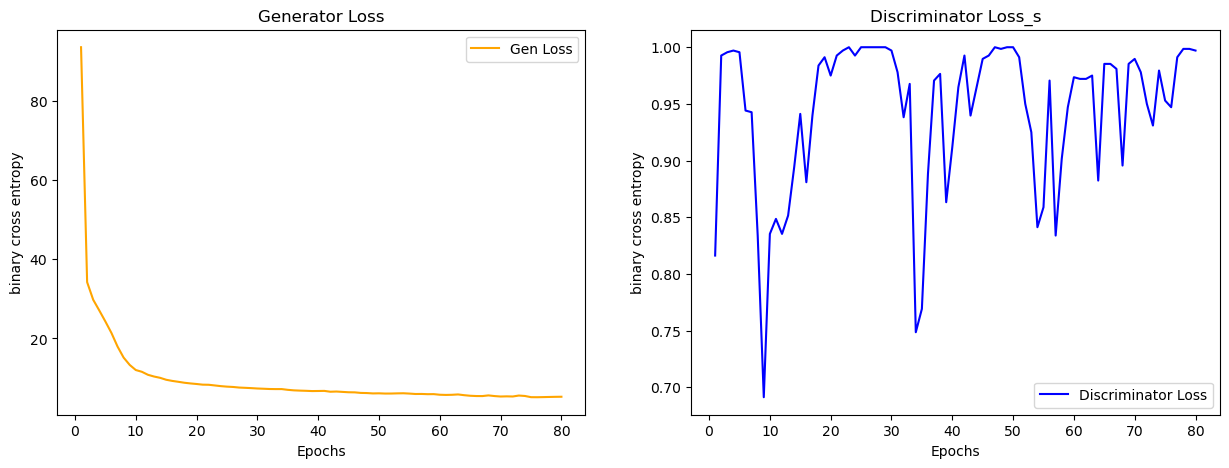

In [23]:
import matplotlib.pyplot as plt
epochs=range(1,len(gen_losses_store)+1)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, gen_losses_store,'orange', label='Gen Loss')
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('binary cross entropy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, dd,'b', label='Discriminator Loss')
plt.title('Discriminator Loss_s')
plt.xlabel('Epochs')
plt.ylabel('binary cross entropy')
plt.legend()

#plt.savefig('plot.jpg',quality=95)
plt.show()
